In [2]:
# A function to load images from a directory and perform preprocessing
from os import walk 
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline



In [4]:
mypath='/Users/Pan/Google Drive/Data Science/Machine Learning/Facial-expression-detection/images'

## Image Reading

In [7]:
jpgfiles = [os.path.join(d, x)
            for d, dirs, files in os.walk(mypath)
            for x in files if x.endswith(".png")] # make sure to change the file extension if needed
jpgfiles[0] #just to check

'/Users/Pan/Google Drive/Data Science/Machine Learning/Facial-expression-detection/images/valid/contempt/m07_dfh_crx.png'

In [24]:
jpgfiles_valid=[img for img in jpgfiles if 'valid' in img]
jpgfiles_train=[img for img in jpgfiles if 'train' in img]
print(len(jpgfiles_valid))
print(len(jpgfiles_train))

177
1635


In [12]:
expressions=['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise']

In [19]:
jpgfiles_valid[0]

'/Users/Pan/Google Drive/Data Science/Machine Learning/Facial-expression-detection/images/valid/contempt/m07_dfh_crx.png'

In [29]:
jpgfiles_valid_lables=[]
for img in jpgfiles_valid:
    for lb in expressions:
        if lb in img:
            jpgfiles_valid_lables.append(lb)

jpgfiles_train_lables=[]
for img in jpgfiles_train:
    for lb in expressions:
        if lb in img:
            jpgfiles_train_lables.append(lb)
print(len(jpgfiles_valid_lables))
print(len(jpgfiles_train_lables))

177
1635


In [8]:
def scale_crop_grayscale_img(img_path,newSize,show_debug_info=False,show_imgs=False,save=False,output_dir=""):
    if show_debug_info:
        print("Input file:%s"%img_path)
    # Load image
    image_org = cv2.imread(img_path)
    h, w, d = image_org.shape
    if show_debug_info:
        print("input shape [%i,%i,%i]"%(h, w,d))
        
    # Change to grayscale
    image_org = cv2.cvtColor(image_org, cv2.COLOR_BGR2GRAY)

    # Scale Down
    if h>w:
        newW=newSize
        newH=int((h/w)*newSize)
    else:
        newW=int((w/h)*newSize)
        newH=newSize
    if show_imgs:    
        plt.imshow(image_org, cmap='gray')
        plt.show()
    resized_image = cv2.resize(image_org, (newW, newH))
    if show_debug_info:
        print("scaled shape [%i,%i]"%(newW, newH))
    if show_imgs:
        plt.imshow(resized_image, cmap='gray')
        plt.show()
        
    # Crop with center preserved    
    center_cropped_image=resized_image
    if newW>newSize or newH>newSize:
        if newW==newSize:
            halfOffSet=int((newH-newSize)/2)
            center_cropped_image=center_cropped_image[halfOffSet:newH-halfOffSet,:]
            if center_cropped_image.shape[0]>newSize:
                center_cropped_image=center_cropped_image[1:,:]
        else:
            halfOffSet=int((newW-newSize)/2)
            center_cropped_image=center_cropped_image[:,halfOffSet:newW-halfOffSet]
            if center_cropped_image.shape[1]>newSize:
                center_cropped_image=center_cropped_image[:,1:]
                
        if show_debug_info:        
            print("output shape:",center_cropped_image.shape)
        if show_imgs:
            plt.imshow(center_cropped_image, cmap='gray')
            plt.show()
    # Save output image
    if save:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        new_path=os.path.join(output_dir, os.path.basename(img_path))
        if show_debug_info:
            print("Output file:%s"%new_path)
        cv2.imwrite(new_path,center_cropped_image)
    return center_cropped_image


In [ ]:
#for file in jpgfiles:
#    scale_crop_grayscale_img(file,240,False,False,True,path-to-output-directory)

# If you want to crop images on the fly:
#out_image= scale_crop_grayscale_img(in_img_file,240)
#To load a grayscale image, use: 
#cv2.imread(file_path,0)
#Before feeding images as input, you need to shape input using:
# np.reshape(input_images,[number-of-images,240,240,1]

## load images

In [31]:
jpgfiles_valid[0]

'/Users/Pan/Google Drive/Data Science/Machine Learning/Facial-expression-detection/images/valid/contempt/m07_dfh_crx.png'

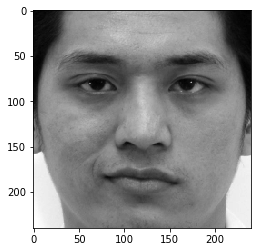

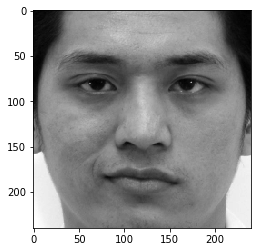

array([[ 11,   8,   8, ...,   5,   6,   6],
       [  8,   8,  10, ...,   5,   6,   6],
       [  9,  10,  10, ...,   5,   6,   7],
       ...,
       [170, 170, 170, ..., 160, 160, 160],
       [170, 170, 170, ..., 160, 161, 160],
       [170, 170, 170, ..., 159, 161, 160]], dtype=uint8)

In [37]:
scale_crop_grayscale_img(img_path=jpgfiles_valid[0], newSize=240, show_imgs=True)

## Build ConvNet

In [9]:
# Load libraries
import tensorflow as tf
import random
import os
import glob

In [10]:
# Basic Functions:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x,name):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME',name=name)
 

def weight_variable(shape,varname):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=varname)


def bias_variable(shape,varname):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=varname)

In [11]:
def deepnn(x):
    # x is 64x64x3
    
    # First Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 3, 16],'conv_w')
        b_conv1 = bias_variable([16],'conv_b')
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1,name='h_conv_op')
        h_pool1 = max_pool_2x2(h_conv1,'h_pool_op')
    # output: 32x32x16
 
    # Second Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 16, 16],'conv_w')
        b_conv2 = bias_variable([16],'conv_b')
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2,name='h_conv_op')
        h_pool2 = max_pool_2x2(h_conv2,'h_pool_op')
    # output: 16x16x16

    # Third Conv, Relu and 2x2 max-pooling layers
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 16, 32],'conv_w')
        b_conv3 = bias_variable([32],'conv_b')
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3,name='h_conv_op')
        h_pool3 = max_pool_2x2(h_conv3,'h_pool_op')
    # output: 8x8x32

    # First Fully Connected Layer
    with tf.name_scope('fc'):
        # Flatten output from previous layer
        h_pool3_flat = tf.reshape(h_pool3, [-1, 8*8*32])
        # Fully connected + Relu
        # input: flat (8x8x32) = 1x2048
        W_fc1 = weight_variable([8 * 8* 32, 1024],'fc_w')
        b_fc1 = bias_variable([1024],'fc_b')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    # output: 1x1024
    
    # Dropout
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32,name="keep_prob")
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Output Softmax Layer: Map the 1024 features to 2 classes, one for each class type
    with tf.name_scope('sm'):
        W_sm = weight_variable([1024, 2],'sm_w')
        b_sm = bias_variable([2],'sm_b')
        y_conv_out = tf.add(tf.matmul(h_fc1_drop, W_sm), b_sm, name="y_conv_op")
 
    return y_conv_out,keep_prob